In [75]:
import sys, os
import time
from rdkit.Chem.Draw import SimilarityMaps
from model.loss import MSE
sys.path.append(os.path.abspath(".."))

import torch
from featurizer.chem_featurizer import default_atom_featurizer, atom_symbol_one_hot,atom_mass
from graph_backends import pytorch_geometric_based as backend
from model.torch_model import PytorchModel
import main
import pandas as pd
import numpy as np

from rdkit import Chem
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
from rdkit.Chem import PandasTools

In [76]:
FP_SIZE = 128
featurizer = default_atom_featurizer


model = PytorchModel(backend.model.GCNMultiInputPredictor(
        in_feats=len(featurizer),
        additional_inputs=0,
        hidden_graph_output=FP_SIZE,
        hidden_feats=[1],
        post_input_module=None,
        n_tasks=FP_SIZE,
        pooling=["mean"],
        ),
                         predict_function=backend.model.GCNMultiInputPredictor.predict_function,
                         batch_data_converter=backend.model.GCNMultiInputPredictor.batch_data_converter,
                         name="circ_proof",
                         dir="circ_proof",
                         )
model.config={"additional_input_names":[],
              "smiles_column":"smiles",
              "backend":"pytorch_geometric",
              "task_names":["fp_{}".format(i) for i in range(FP_SIZE)]
              }
model.gcn_featurizer = featurizer
optimizer = torch.optim.Adam(model.module.parameters(), lr=0.01)
loss_fn = MSE()

model.compile(optimizer, loss_fn, metrics="relmae")


[1]


In [77]:
base_smiles="[CH2][C](C)(C(=O)OC)"
#base_smiles="[N]=[P]"
Chem.MolFromSmiles(base_smiles)

n=40

load data 39/39 (100.00%)    


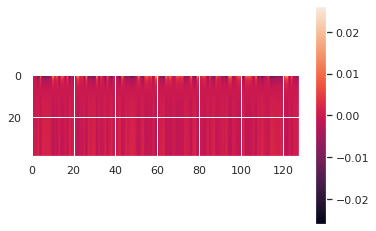

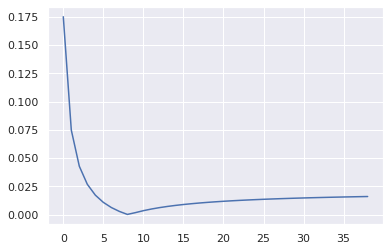

In [78]:
df=pd.DataFrame(columns=["smiles"])

for i in range(1,n,1):
    s=base_smiles*int(i)
    df.loc[i-1]={"smiles":s}

def catch(feats,data):
    return
    #print(feats.cpu().numpy().shape,data)
    for b in data.batch.unique():
        #print(feats[data.batch == b])
        fig = SimilarityMaps.GetSimilarityMapFromWeights(data.mol[b],
                                                         feats[data.batch == b].cpu().numpy(),
                                                         colorMap='jet', contourLines=10)
        plt.show()
        plt.close()

model.module.catch = catch

pred_df = main.predict(model,df)
pred_values = pred_df[["predicted_{}".format(tn) for tn in model.config["task_names"]]].values
distance_vec = pred_values - pred_values.mean(axis=0)
plt.imshow(distance_vec.astype(float))
plt.colorbar()
plt.show()
plt.close()
distances = np.array([np.linalg.norm(distance_vec[i]) for i in range(distance_vec.shape[0])])
plt.plot(distances)
plt.show()
plt.close()

load data 39/39 (100.00%)    


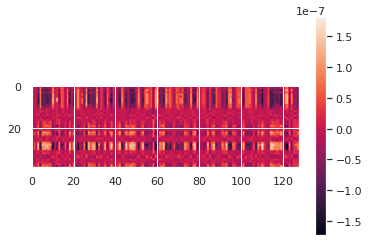

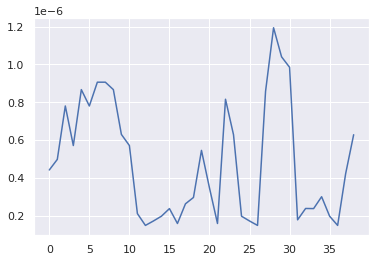

In [79]:
df=pd.DataFrame(columns=["smiles"])

for i in range(1,n,1):
    s=base_smiles.replace("]","]1",1)+base_smiles*int(i)+"1"
    df.loc[i-1]={"smiles":s}
pred_df = main.predict(model,df)
pred_values = pred_df[["predicted_{}".format(tn) for tn in model.config["task_names"]]].values
distance_vec = pred_values - pred_values.mean(axis=0)
plt.imshow(distance_vec.astype(float))
plt.colorbar()
plt.show()
plt.close()
distances = np.array([np.linalg.norm(distance_vec[i]) for i in range(distance_vec.shape[0])])
plt.plot(distances)
plt.show()
plt.close()

load data 40/40 (100.00%)    


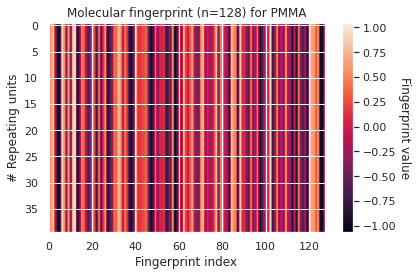

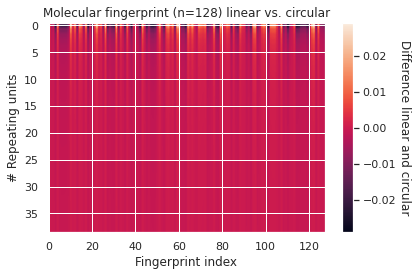

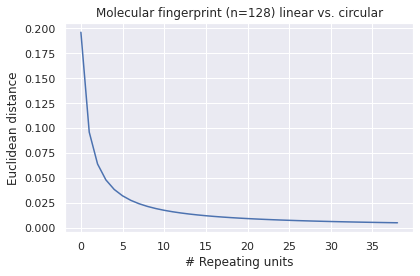

In [175]:
df=pd.DataFrame(columns=["smiles"])

s=base_smiles.replace("]","]1",1)+base_smiles*10+"1"
df.loc[0]={"smiles":s}
for i in range(1,n,1):
    s=base_smiles*int(i)
    df.loc[i]={"smiles":s}
pred_df = main.predict(model,df)
pred_values = pred_df[["predicted_{}".format(tn) for tn in model.config["task_names"]]].values
distance_vec = pred_values[1:] - pred_values[0]
plt.imshow(pred_values.astype(float), aspect='auto')
plt.title("Molecular fingerprint (n={}) for PMMA".format(FP_SIZE))
plt.ylabel("# Repeating units")
plt.xlabel("Fingerprint index")
cbar = plt.colorbar()
cbar.set_label('Fingerprint value', rotation=270, labelpad=15)
plt.tight_layout()
plt.savefig("circ_proof_fp.png",dpi=300)
plt.show()
plt.close()

plt.imshow(distance_vec.astype(float), aspect='auto')
plt.title("Molecular fingerprint (n={}) linear vs. circular".format(FP_SIZE))
plt.ylabel("# Repeating units")
plt.xlabel("Fingerprint index")
cbar = plt.colorbar()
cbar.set_label('Difference linear and circular', rotation=270, labelpad=15)
plt.tight_layout()
plt.savefig("circ_proof_diff_fp.png",dpi=300)
plt.show()
plt.close()

distances = np.array([np.linalg.norm(distance_vec[i]) for i in range(distance_vec.shape[0])])
plt.plot(distances)
plt.title("Molecular fingerprint (n={}) linear vs. circular".format(FP_SIZE))
plt.xlabel("# Repeating units")
plt.ylabel("Euclidean distance")
plt.tight_layout()
plt.savefig("circ_proof_euclid_dist.png",dpi=300)
plt.show()
plt.close()

1
21
41
61
81
101
121
141
161
181
201
221
241
261
281
301
321
341
361
381
401
421
441
461
481
501
521
541
561
581
601
621
641
661
681
701
721
741
761
781
801
821
841
861
881
901
921
941
961
981


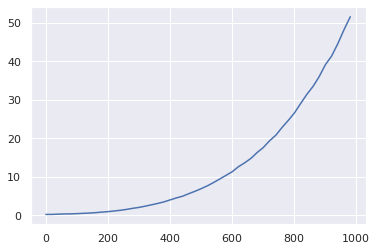

In [16]:
times=[]
mmax=1000
speed_lim=200
speed_delta = 20
nrange = np.concatenate([np.arange(1,speed_lim+1,1),np.arange(speed_lim+1,mmax+speed_delta,speed_delta)])
k=0
for i in nrange:
    print(i,end="\r")
    df=pd.DataFrame(columns=["smiles"])
    s=base_smiles*int(i)
    df.loc[0]={"smiles":s}
    t=time.time()
    for j in range(0,k):
        pred_df = main.predict(model,df,verbose=False)
    times.append((time.time()-t)/k)
times=np.array(times)

In [137]:
k=100
s=base_smiles.replace("]","]1",1)+base_smiles*10+"1"
df=pd.DataFrame(columns=["smiles"])
df.loc[0]={"smiles":s}
t=time.time()
for j in range(0,k):
    pred_df = main.predict(model,df,verbose=False)
circ_time = (time.time()-t)/k

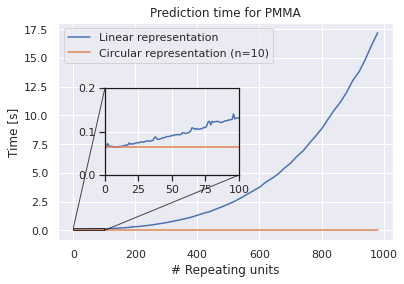

In [176]:
fig, ax = plt.subplots()
ax.plot(nrange,times,label="Linear representation")
ax.plot(nrange,np.ones_like(times)*circ_time,label="Circular representation (n=10)")
with plt.rc_context({'axes.edgecolor':'k',
                     'xtick.bottom':True, 'ytick.left':True
                     }) :
    axins = ax.inset_axes([0.14, 0.3, 0.4, 0.4])
    axins.plot(nrange,times)
    axins.plot(nrange,np.ones_like(times)*circ_time)
    axins.set_xlim(0, 100)
    axins.set_ylim(0, 0.2)

    #axins.set_xticklabels('')
    #axins.set_yticklabels('')


plt.title("Prediction time for PMMA")
plt.xlabel("# Repeating units")
plt.ylabel("Time [s]")
plt.legend()
ax.indicate_inset_zoom(axins,alpha=0.7,edgecolor='0')
plt.savefig("circ_proof_calc_time.png",dpi=300)